In [1]:
# Step 1: Define constants

import numpy as np
from torch.nn import CrossEntropyLoss, NLLLoss

# Run specific
DATASET = "fashion-mnist" # "mnist", "fashion-mnist", "cifar"
PERTURB = False
SIMPLE_NEURONS_PER_FEATURE_PER_ROW = 8
CHOOSE_NEW_RECEPTIVE_FIELDS = False
CHOOSE_NEW_TRAINING_DATA = False
FORCE_EXTRACT_FEATURES = False
RUN = "3"
# Constants
CLASSES = 4
BATCH_SIZE = 256
FEATURE_BRIGHTNESS = 2
FEATURE_ANGLES = 2
FEATURE_FREQUENCIES = 1

#For dynamic kernels
KERNEL="dynamic"
MIN_KERNEL_SIZE = 5
MIN_KERNEL_SIZE_GABOR = 2

#Derived:
TOTAL_FEATURES_PER_SITE = FEATURE_BRIGHTNESS + FEATURE_ANGLES * FEATURE_FREQUENCIES * 2 # 2 values per gabor
TOTAL_FEATURES = SIMPLE_NEURONS_PER_FEATURE_PER_ROW * SIMPLE_NEURONS_PER_FEATURE_PER_ROW * TOTAL_FEATURES_PER_SITE

FILENAME_PREFIX = f'v3-{DATASET}-r{RUN}-n{TOTAL_FEATURES}-k{KERNEL}'

if DATASET == "cifar":
  IMAGE_WIDTH = 32
  TARGETS = np.array(["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"])  
elif DATASET == "fashion-mnist":
  IMAGE_WIDTH = 28
  TARGETS = np.array(["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]) 
else: 
  IMAGE_WIDTH = 28
  TARGETS = np.array([0,1,2,3,4,5,6,7,8,9])

## Settings
DEBUG = False


In [2]:
# Step 2: Necessary imports

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle, Arrow
from itertools import cycle
import random
import os.path as path
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from datetime import datetime

# Additional torch-related imports
import torch
from torch import Tensor, cat, no_grad, manual_seed
from torch.nn import Linear, MSELoss, Softmax
from torch.optim import LBFGS
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim

# Project specific imports
from canonicallayers.brightnessextractor import extractBrightness, extractBrightnessAt
from canonicallayers.gaborfilterextractor import extract_power_feats
from canonicallayers.perturbations import skew, rotate, noise, elastic_transform
algorithm_globals.random_seed = 42

In [3]:
# Step 3: Prepare Training data
# -------------

# Set train shuffle seed (for reproducibility)
manual_seed(42)

batch_size = BATCH_SIZE
n_samples = CLASSES * 10000  # We will concentrate on the first 6000 * CLASSES samples

if(CHOOSE_NEW_TRAINING_DATA or (not path.isfile(f'checkpoints/{FILENAME_PREFIX}-training.pt'))):
  print("Creating new training set...")
  # Use pre-defined torchvision function to load MNIST train data
  if DATASET == "cifar":
    X_train = datasets.CIFAR10(
        root="./data", train=True, download=True, transform=transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.ToTensor()])
    )
  elif DATASET == "fashion-mnist":
    X_train = datasets.FashionMNIST(
        root="./data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()])
    )    
  else:
    X_train = datasets.MNIST(
        root="./data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()])
    )    
  # Filter out labels (originally 0-9), leaving only labels 0 and 1
  idx = np.where(np.array(X_train.targets) < CLASSES)[0][:n_samples]
  X_train.data = X_train.data[idx]
  X_train.targets = np.array(X_train.targets)[idx]

  print("X_train.data", X_train.data.shape)
  # Define torch dataloader with filtered data
  train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)
  torch.save(train_loader, f'checkpoints/{FILENAME_PREFIX}-training.pt')
else:
  print("loading existing training set...")
  train_loader = torch.load(f'checkpoints/{FILENAME_PREFIX}-training.pt')

Creating new training set...
X_train.data torch.Size([24000, 28, 28])


images shape torch.Size([256, 1, 28, 28])


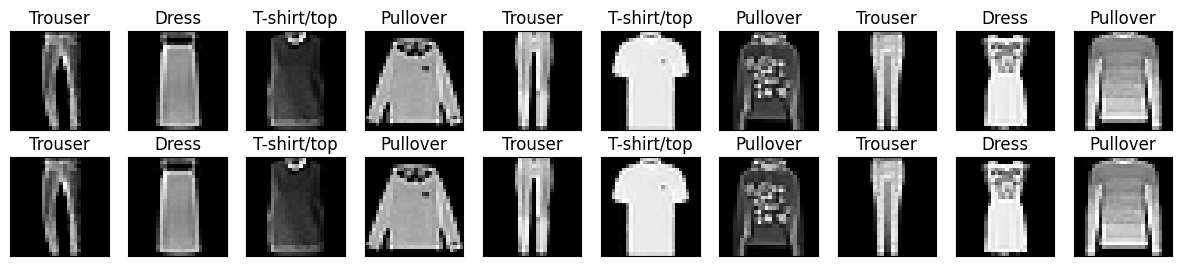

In [4]:
# Step 4 - Visualize dataset

n_samples_show = 10

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=2, ncols=n_samples_show, sharex=True, figsize=(15, 3))
images, targets = data_iter.__next__()
print("images shape", images.shape)

while n_samples_show > 0:
    originalImage = images[n_samples_show,0]
      
    if(PERTURB):
      perturbation = "none"
      match random.randint(0, 3):
          case 0:
            perturbedImage = skew(originalImage.numpy())
            perturbation = "skew"
          case 1:
            angle = 3*np.random.random()/5
            perturbedImage = rotate(originalImage.numpy(), angle)
            perturbation = f"rotate {np.round(angle*180/np.pi)}°"
          case 2:
            perturbedImage = noise(originalImage.numpy())
            perturbation = "noise"
          case _:
            perturbedImage = elastic_transform(originalImage.numpy())
            perturbation = "elastic"
      perturbedData = torch.tensor(perturbedImage).unsqueeze(0).unsqueeze(0)

    axes[0,n_samples_show - 1].imshow(originalImage.numpy().squeeze(), cmap="gray")
    axes[0,n_samples_show - 1].set_xticks([])
    axes[0,n_samples_show - 1].set_yticks([])
    axes[0,n_samples_show - 1].set_title(TARGETS[targets[n_samples_show].item()])
    if(PERTURB):
      axes[1,n_samples_show - 1].imshow(perturbedData[0].numpy().squeeze(), cmap="gray")
      axes[1,n_samples_show - 1].set_xticks([])
      axes[1,n_samples_show - 1].set_yticks([])
      axes[1,n_samples_show - 1].set_title("{}".format(perturbation))
    else:
      axes[1,n_samples_show - 1].imshow(originalImage.numpy().squeeze(), cmap="gray")
      axes[1,n_samples_show - 1].set_xticks([])
      axes[1,n_samples_show - 1].set_yticks([])
      axes[1,n_samples_show - 1].set_title(TARGETS[targets[n_samples_show].item()])

    n_samples_show -= 1

In [5]:
# Step 6 - Setup Feature Extraction parameters

dataWidth = SIMPLE_NEURONS_PER_FEATURE_PER_ROW
imgWidth = IMAGE_WIDTH - MIN_KERNEL_SIZE +1
gaborImgWidth = IMAGE_WIDTH - MIN_KERNEL_SIZE +1 # IMAGE_WIDTH - MIN_KERNEL_SIZE_GABOR +1

if(CHOOSE_NEW_RECEPTIVE_FIELDS or (not path.isfile(f'checkpoints/{FILENAME_PREFIX}-gaborReceptiveFields.pt'))): 
  print("Creating new gabor filters...")
  gaborReceptiveFields = torch.randint(0,gaborImgWidth * gaborImgWidth, (dataWidth, dataWidth))
  gaborKernels = torch.clone(gaborReceptiveFields)
  gaborKernels = gaborKernels.apply_(lambda x: random.randint(
    MIN_KERNEL_SIZE, 
    min([(IMAGE_WIDTH-x//gaborImgWidth), (IMAGE_WIDTH-x%gaborImgWidth)])))
  gaborAngleTunings = torch.FloatTensor(FEATURE_ANGLES, dataWidth, dataWidth).uniform_(0, np.pi)
  gaborFrequencyTunings = torch.FloatTensor(FEATURE_FREQUENCIES, dataWidth, dataWidth).uniform_(1./10., 1./2.)
  gaborBrightnessTunings = torch.FloatTensor(FEATURE_BRIGHTNESS, dataWidth, dataWidth).uniform_(-0.5, 1.0)

  torch.save(gaborReceptiveFields, f"checkpoints/{FILENAME_PREFIX}-gaborReceptiveFields.pt")
  torch.save(gaborKernels, f"checkpoints/{FILENAME_PREFIX}-gaborKernels.pt")
  torch.save(gaborAngleTunings, f"checkpoints/{FILENAME_PREFIX}-gaborAngleTunings.pt")
  torch.save(gaborFrequencyTunings, f"checkpoints/{FILENAME_PREFIX}-gaborFrequencyTunings.pt")
  torch.save(gaborBrightnessTunings, f"checkpoints/{FILENAME_PREFIX}-gaborBrightnessTunings.pt")
else:
  print("loading existing gabor filters...", f"checkpoints/{FILENAME_PREFIX}-gaborReceptiveFields.pt")
  gaborReceptiveFields = torch.load(f"checkpoints/{FILENAME_PREFIX}-gaborReceptiveFields.pt")
  gaborKernels = torch.load(f"checkpoints/{FILENAME_PREFIX}-gaborKernels.pt")
  gaborAngleTunings = torch.load(f"checkpoints/{FILENAME_PREFIX}-gaborAngleTunings.pt")
  gaborFrequencyTunings = torch.load(f"checkpoints/{FILENAME_PREFIX}-gaborFrequencyTunings.pt")
  gaborBrightnessTunings = torch.load(f"checkpoints/{FILENAME_PREFIX}-gaborBrightnessTunings.pt")


Creating new gabor filters...


In [6]:
# Step 17 - Plot feature extraction kernels

def plotKernel(ax, locations, kernels, brightnessTunings, angleTunings, title, feature):
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(title)
  imgWidth = IMAGE_WIDTH - MIN_KERNEL_SIZE +1
  ax.plot([0, 0],[IMAGE_WIDTH, IMAGE_WIDTH])
  cycol = cycle('bgrcmk')
  Y = []
  X = []
  C=[]
  S=[]
  kernelSize=[]
  tuningX=[]
  tuningY=[]
  tuningValue=np.array([])
  anyOneTuningValue = []
  # print("locations", locations.shape, "angleTunings", angleTunings)
  for iy, ix in np.ndindex(locations.shape):
    # if(angleTunings.shape[0] < iy+1):
    #   print("breaking", "angleTunings.shape", angleTunings.shape, "iy+1", iy+1)
    #   break
    y = locations[iy, ix] // imgWidth
    x = locations[iy, ix] % imgWidth
    Y.append(y.item())
    X.append(x.item())
    ks = kernels[iy, ix].item()
    # print("ks", ks)
    kernelSize.append(ks * ks * 2000/(IMAGE_WIDTH*IMAGE_WIDTH))
    tuningX.append(x + ks/2)
    tuningY.append(y + ks/2)
    size = kernels[iy, ix].item()
    S.append(size)
    # print("iy", iy, "ix", ix, "angleTunings[iy, ix]", angleTunings[iy, ix].shape, "tuningValue", len(tuningValue))
    tuningValue = np.concatenate((tuningValue, angleTunings[:, iy, ix].numpy()))
    anyOneTuningValue.append(np.random.choice(angleTunings[:, iy, ix].numpy().astype(int)))
    angles = angleTunings[:, iy, ix].numpy()
    brightnesses = brightnessTunings[:, iy, ix].numpy()
    topX = x.item()
    topY = IMAGE_WIDTH-y.item()-size
    radius = 1
    centerX = topX + int(size/2)
    centerY = topY + int(size/2)
    color = next(cycol)
    if(feature == "kernel"):
      ax.add_patch(Rectangle((topX, topY), size, size, facecolor= 'none', edgecolor=color, alpha=0.5))
    
    # ax.add_patch(Circle((centerX, centerY), radius=radius, alpha=0.1))
    for a in angles:
      dx = int((size/2) * np.cos(a))
      dy = - int((size/2) * np.sin(a))
      # print("center", centerX, centerY, "angle", a * 180/np.pi, "size", size, "dx", dx, "dy", dy)
      if(feature == "angle"):
        ax.add_patch(Arrow(centerX, centerY, dx, dy, alpha=0.2, facecolor=color))
    for br in brightnesses:
      if(feature == "brightness"):
        ax.add_patch(Circle((centerX, centerY), radius=size*br/3, alpha=0.15, facecolor=color))

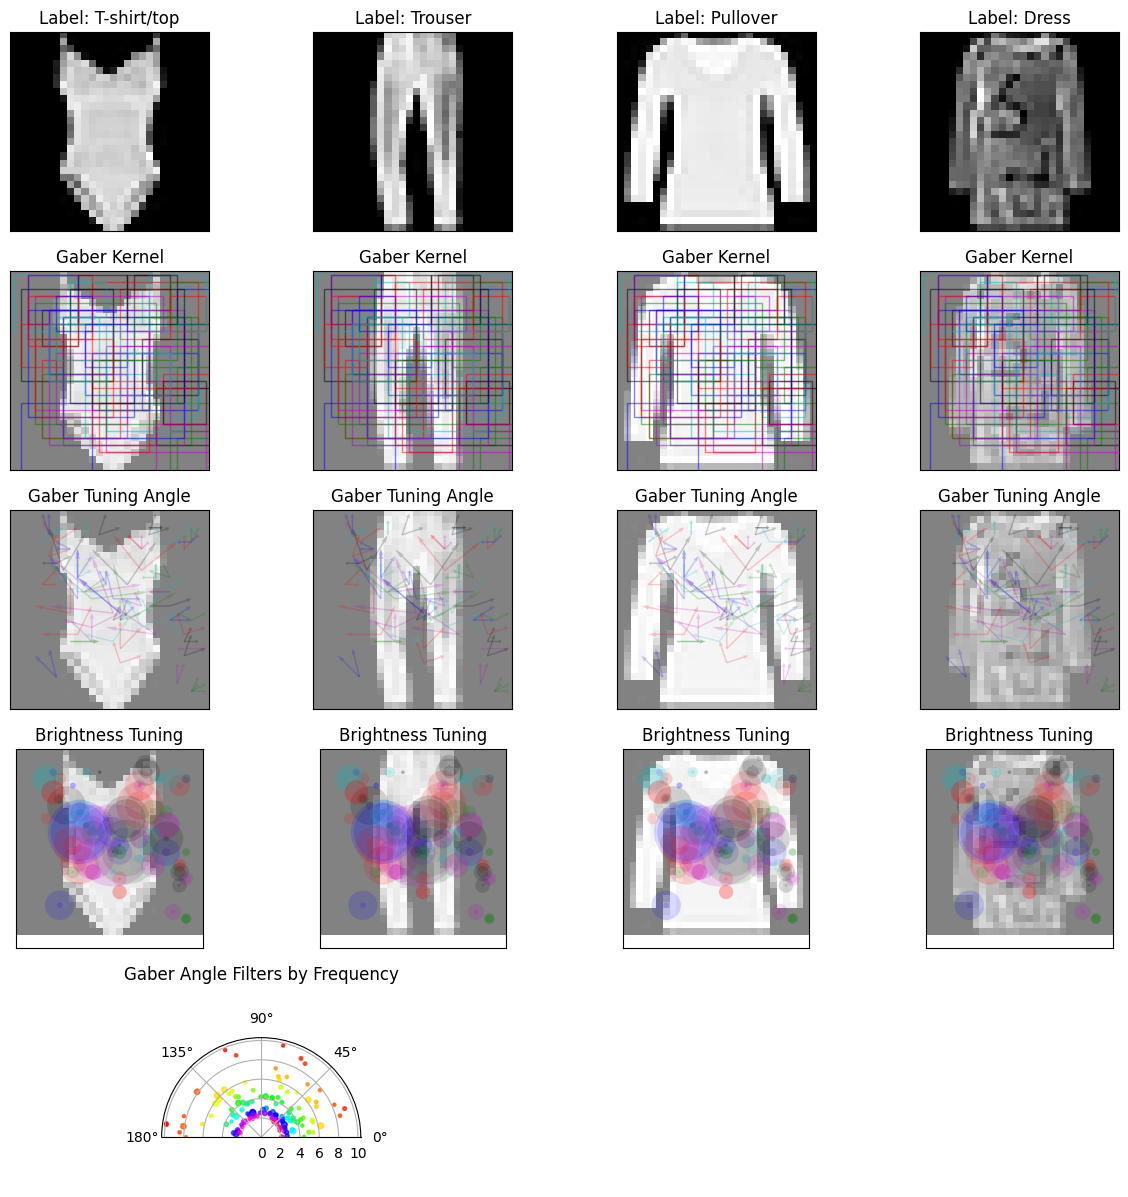

In [7]:
# Step 18 - Predict
def plot(axes, count, data, idx, perturbations, target, feature):
  perturbedData = data[idx,0, :, :].unsqueeze(1)
  axes[0,count].imshow(perturbedData[0].numpy().squeeze(), cmap="gray")
  axes[0,count].set_xticks([])
  axes[0,count].set_yticks([])
  if(PERTURB):
    axes[0,count].set_title("{}, Label: {}".format(perturbations[idx], TARGETS[target[idx].item()]))
  else:
    axes[0,count].set_title("Label: {}".format(TARGETS[target[idx].item()]))
  axes[1,count].imshow(perturbedData[0].numpy().squeeze(), cmap="gray", alpha=0.2)
  axes[2,count].imshow(perturbedData[0].numpy().squeeze(), cmap="gray", alpha=0.2)
  axes[3,count].imshow(perturbedData[0].numpy().squeeze(), cmap="gray", alpha=0.2)
  if(feature == "kernel"):
    plotKernel(axes[1,count], gaborReceptiveFields, gaborKernels, gaborBrightnessTunings, gaborAngleTunings, "Gaber Kernel", feature)
  elif(feature == "angle"):
    plotKernel(axes[2,count], gaborReceptiveFields, gaborKernels, gaborBrightnessTunings, gaborAngleTunings, "Gaber Tuning Angle", feature)
  elif(feature == "brightness"):
    plotKernel(axes[3,count], gaborReceptiveFields, gaborKernels, gaborBrightnessTunings, gaborAngleTunings, "Brightness Tuning", feature)


fig, axes = plt.subplots(nrows=5, ncols=CLASSES, figsize=(15, 15))

dataWidth = SIMPLE_NEURONS_PER_FEATURE_PER_ROW
imgWidth = IMAGE_WIDTH - MIN_KERNEL_SIZE +1

for batch_idx, (data, target) in enumerate(train_loader):
  perturbations = []
  # print("target", target.shape)
  class1Indices = (target == 0).nonzero()
  class2Indices = (target == 1).nonzero()
  class3Indices = (target == 2).nonzero()
  class4Indices = (target == 3).nonzero()
  plot(axes, 0, data, class1Indices[0], perturbations, target, "angle")
  plot(axes, 1, data, class2Indices[0], perturbations, target, "angle")
  plot(axes, 2, data, class3Indices[0], perturbations, target, "angle")
  plot(axes, 3, data, class4Indices[0], perturbations, target, "angle")

  plot(axes, 0, data, class1Indices[0], perturbations, target, "kernel")
  plot(axes, 1, data, class2Indices[0], perturbations, target, "kernel")
  plot(axes, 2, data, class3Indices[0], perturbations, target, "kernel")
  plot(axes, 3, data, class4Indices[0], perturbations, target, "kernel")

  plot(axes, 0, data, class1Indices[0], perturbations, target, "brightness")
  plot(axes, 1, data, class2Indices[0], perturbations, target, "brightness")
  plot(axes, 2, data, class3Indices[0], perturbations, target, "brightness")
  plot(axes, 3, data, class4Indices[0], perturbations, target, "brightness")


  axes[4,0].remove()
  axes[4,1].remove()
  axes[4,2].remove()
  axes[4,3].remove()

  ax = fig.add_subplot(5, 4, (17, 18), projection='polar')
  ax.set_title("Gaber Angle Filters by Frequency")
  ax.set_thetamin(0)
  ax.set_thetamax(180)
  cTunings = gaborAngleTunings.unsqueeze(0).repeat(FEATURE_FREQUENCIES, 1,1,1)
  cFrequencies = gaborFrequencyTunings.unsqueeze(1).repeat(1, FEATURE_ANGLES, 1,1)
  cKernels = gaborKernels.unsqueeze(0).unsqueeze(1).repeat(FEATURE_FREQUENCIES, FEATURE_ANGLES, 1,1)

  # print("gaborAngleTunings", gaborAngleTunings.unsqueeze(0).shape, "gaborFrequencyTunings", gaborFrequencyTunings.unsqueeze(1).shape, "gaborKernels", gaborKernels.unsqueeze(0).unsqueeze(1).shape)
  ax.scatter(cTunings, 1/cFrequencies, c=cFrequencies, s=cKernels, cmap='hsv', alpha=0.75)
  break


In [8]:
import qiskit.tools.jupyter

%qiskit_version_table